In [55]:
import pandas as pd
import numpy as np
import hddm
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from kabuki.analyze import gelman_rubin

In [122]:
#set number of synthetic subjects and amount of trial to generate per subject
subjects = 66
trials = 160

In [150]:
#create array with all combinations of three values for a, t, scaler and alpha
x = np.array([(a, t, scaler, alpha)
              for a in np.linspace(1.3,1.4,num=2) 
              for t in np.linspace(0.16,0.17,num=2) 
              for scaler in np.linspace(1.9, 2,num=2) 
              for alpha in np.linspace(-0.25, 3.3,num=2)
              # for pos_alpha in np.linspace(-1.7,0.55,num=2)
              ])
f = pd.DataFrame(data=x,columns=['a','t', 'scaler', 'alpha'])

In [151]:
f.head()

,a,t,scaler,alpha
0,1.3,0.16,1.9,-0.25
1,1.3,0.16,1.9,3.30
2,1.3,0.16,2.0,-0.25
3,1.3,0.16,2.0,3.30
4,1.3,0.17,1.9,-0.25


In [152]:
f.shape

(16, 4)

In [153]:
#generate data, estimate model and save traces and convergence info for all combinations of models
#this will take a while, so sending these as jobs on a cluster is recommended
for i in range(f.shape[0]):
    print(i)
    data = hddm.generate.gen_rand_rlddm_data(
        a=f.a[i], 
        alpha=f.alpha[i], 
        # pos_alpha=f.pos_alpha[i], 
        scaler=f.scaler[i],
        t=f.t[i],
        size=trials,
        subjs=subjects,
        p_upper=0.90,
        p_lower=0.10)
    data['q_init'] = 0.5
    models = []
    for a in range(2):  
        m = hddm.HDDMrl(data=data)
        m.sample(500, burn=200,dbname='traces.db',db='pickle')
        models.append(m)
    gelman = gelman_rubin(models)
    gelman = pd.DataFrame.from_dict(gelman,orient='index')
    convergencename = 'convergence_model%s.csv'%(i)
    gelman.to_csv(convergencename)
    traces = m.get_traces()
    filename = 'traces_model%s.csv'%(i)
    traces.to_csv(filename)

0


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/hddm/generate.py:194: RuntimeWarning: invalid value encountered in true_divide
  size, range_[0], range_[1], dt)


 [-----------------100%-----------------] 500 of 500 complete in 99.3 secc1
 [-----------------100%-----------------] 500 of 500 complete in 93.3 sec2
 [-----------------100%-----------------] 501 of 500 complete in 110.5 sec3
 [-----------------100%-----------------] 501 of 500 complete in 90.3 sec4
 [-----------------100%-----------------] 500 of 500 complete in 117.4 sec5
 [-----------------100%-----------------] 500 of 500 complete in 94.7 secc6
 [-----------------100%-----------------] 500 of 500 complete in 113.0 sec7
 [-----------------100%-----------------] 500 of 500 complete in 95.6 sec8
 [-----------------100%-----------------] 500 of 500 complete in 106.6 sec9
 [-----------------100%-----------------] 500 of 500 complete in 97.0 sec10
 [-----------------100%-----------------] 501 of 500 complete in 108.9 sec11
 [-----------------100%-----------------] 501 of 500 complete in 96.7 sec12
 [-----------------100%-----------------] 500 of 500 complete in 108.1 sec13
 [-----------

In [154]:
gelmans = hddm.load_csv('convergence_model0.csv').T
gelmans.columns = gelmans.iloc[0]
gelmans = gelmans.drop('Unnamed: 0',axis=0)
conv = gelmans

for i in range(1,f.shape[0]):
    filename = 'convergence_model%i.csv' %(i)
    gelmans = hddm.load_csv(filename).T
    gelmans.columns = gelmans.iloc[0]
    gelmans = gelmans.drop('Unnamed: 0',axis=0)
    conv = conv.append(gelmans)            
conv = conv.apply(pd.to_numeric)

In [155]:
#proportion parameters that did not converge when not using find_starting and sample at 3000 and burnin 1500
conv = pd.melt(conv, var_name="Parameter", value_name="Value")
np.mean(conv['Value'] > 1.1)

0.37155330882352944

In [156]:
conv.describe()

,Value
count,4352.000000
mean,3.724404
std,29.906403
min,0.998332
25%,1.001126
50%,1.020518
75%,1.570286
max,1216.245664


In [157]:
traces = hddm.load_csv('traces_model0.csv')
tg = traces[traces.columns.drop(list(traces.filter(regex='subj')))]
means = pd.DataFrame(tg.mean(axis=0)).T
means.append(means)

,Unnamed: 0,a,a_std,v,v_std,t,t_std,alpha,alpha_std
0,149.5,0.844317,0.041487,-7.470487,1.728152,0.133724,0.055364,-0.232503,0.004275
0,149.5,0.844317,0.041487,-7.470487,1.728152,0.133724,0.055364,-0.232503,0.004275


In [158]:
# Creating an empty Dataframe with column names only
means = pd.DataFrame(columns=['Unnamed: 0','a','a_std','alpha','alpha_std', 't','t_std','v','v_std','cor_at'])

for i in range(1,f.shape[0]):
    filename = 'traces_model%i.csv' %(i)
    traces = hddm.load_csv(filename)
    tg = traces[traces.columns.drop(list(traces.filter(regex='subj')))]
    summ = pd.DataFrame(tg.mean(axis=0)).T
    summ['cor_at'] = np.corrcoef(tg['a'],tg['t'])[1,0]
    means = means.append(summ)
means.columns = ['trace','e_a','e_a_std','e_alpha','e_alpha_std', 'e_t','e_t_std','e_v','e_v_std','cor_at']
means['e_alphaT'] = np.exp(means['e_alpha'])/(1+np.exp(means['e_alpha']))

In [159]:
means.describe()

,trace,e_a,e_a_std,e_alpha,e_alpha_std,e_t,e_t_std,e_v,e_v_std,cor_at,e_alphaT
count,15.0,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,149.5,1.628106,0.665829,1.891434,0.846315,0.181759,0.115795,-15.675881,9.365615,-0.066701,0.554440
std,0.0,0.838192,1.445034,4.850089,0.772180,0.068372,0.152780,19.693869,10.207482,0.103528,0.486043
min,149.5,1.265947,0.032707,-3.075714,0.044545,0.121672,0.044173,-40.269247,0.224300,-0.234312,0.044120
25%,149.5,1.302772,0.136333,-2.977583,0.097339,0.145955,0.050939,-34.916716,0.262400,-0.149180,0.048467
50%,149.5,1.374518,0.155231,3.957827,0.787421,0.162972,0.057195,1.916844,0.293552,-0.057597,0.981254
75%,149.5,1.507917,0.291321,5.899398,1.615774,0.188805,0.066076,1.995976,18.406283,-0.034980,0.997135
max,149.5,4.599109,5.723410,9.534343,2.095030,0.402841,0.622803,2.076655,23.552571,0.150346,0.999928


In [160]:
#make in long format to plot all in one figure
f.reset_index(drop=True, inplace=True)
means.reset_index(drop=True, inplace=True)
a=pd.DataFrame({'sim':f['a'],'parameter':'a','est':means['e_a']})
t=pd.DataFrame({'sim':f['t'],'parameter':'t','est':means['e_t']})
alpha=pd.DataFrame({'sim':f['alpha'],'parameter':'alpha','est':means['e_alphaT']})
# pos_alpha=pd.DataFrame({'sim':f['pos_alpha'],'parameter':'pos_alpha','est':means['e_pos_alphaT']})
scaler=pd.DataFrame({'sim':f['scaler'],'parameter':'scaler','est':means['e_v']})
long = a
long = long.append(t)
long = long.append(scaler)
long = long.append(alpha)
# long = long.append(pos_alpha)
long['error'] = np.absolute(long['est']-long['sim'])
long.head()

,sim,parameter,est,error
0,1.3,a,1.296944,0.003056
1,1.3,a,1.867768,0.567768
2,1.3,a,1.265947,0.034053
3,1.3,a,1.579877,0.279877
4,1.3,a,1.279772,0.020228


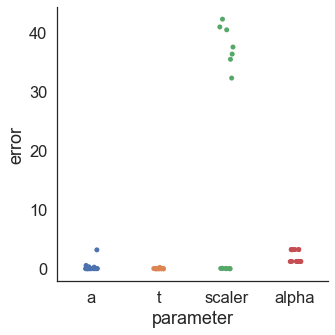

In [161]:
#plot absolute error
g = sns.catplot(x='parameter',y='error',sharey=False,data=long)
# g.savefig('absolute_error.pdf')

In [162]:
def plot_hline(y,**kwargs):
    data = kwargs.pop("data") #get the data frame from the kwargs
    plt.axhline(y=y, c='black',linestyle='-',zorder=-1) #zorder places the line underneath the other points

sns.set(font_scale=1.5)
sns.set_style("white")

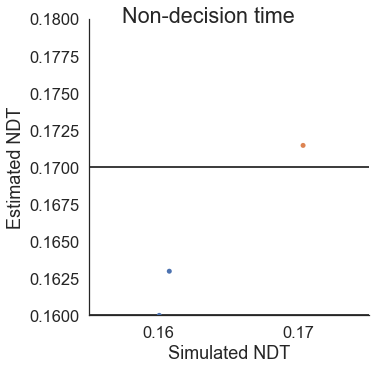

In [163]:
#plot NDT
g = sns.catplot(x='sim',y='est',data=long[long.parameter=='t'])
g.map_dataframe(plot_hline,y=0.16)
g.map_dataframe(plot_hline,y=0.17)
plt.ylim(0.16,0.18)
g.fig.suptitle("Non-decision time")
g.set_axis_labels("Simulated NDT", "Estimated NDT")

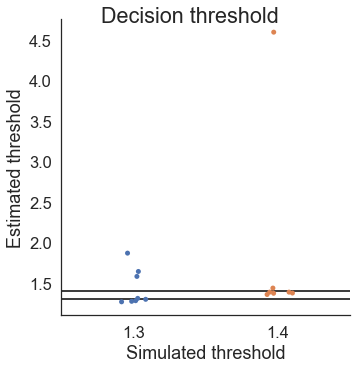

In [164]:
#plot Decision threshold
g = sns.catplot(x='sim',y='est',data=long[long.parameter=='a'])
g.map_dataframe(plot_hline,y=1.3)
g.map_dataframe(plot_hline,y=1.4)
g.fig.suptitle("Decision threshold")
g.set_axis_labels("Simulated threshold", "Estimated threshold")

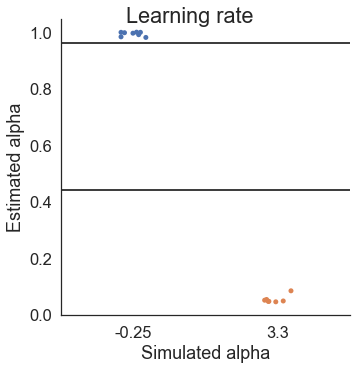

In [165]:
#plot alpha
g = sns.catplot(x='sim',y='est',data=long[long.parameter=='alpha'])
g.map_dataframe(plot_hline,y=0.44)
g.map_dataframe(plot_hline,y=0.96)
g.fig.suptitle("Learning rate")
g.set_axis_labels("Simulated alpha", "Estimated alpha")

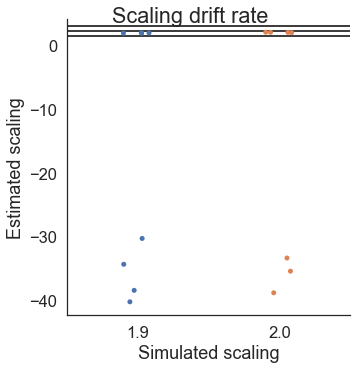

In [166]:
#plot scaling
g = sns.catplot(x='sim',y='est',data=long[long.parameter=='scaler'])
g.map_dataframe(plot_hline,y=1.5)
g.map_dataframe(plot_hline,y=2.25)
g.map_dataframe(plot_hline,y=3)
g.fig.suptitle("Scaling drift rate")
g.set_axis_labels("Simulated scaling", "Estimated scaling")